# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image


## Visualisation Helpers

In [2]:
# Load and preprocess the sample image
image = Image.open('imgnet_sample.JPEG')

# Transform to resize the image and convert to tensor
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),
])

x = transform(image).unsqueeze(0)  # batch dimension

print("Input shape:", x.shape)  # [1, C, H, W]

Input shape: torch.Size([1, 3, 64, 64])


In [3]:
def visualize_feature_maps(feature_maps, title='Feature Maps'):
    feature_maps = feature_maps.squeeze(0)  # Remove batch dimension
    num_channels = feature_maps.shape[0]
    
    fig, axs = plt.subplots(1, num_channels, figsize=(15, 5))
    for idx in range(num_channels):
        axs[idx].imshow(feature_maps[idx].detach().cpu().numpy(), cmap='gray')
        axs[idx].axis('off')
    plt.suptitle(title)
    plt.show()

def visualize_attention_map(attention_map, H, W, title='Attention Map'):
    attention_map = attention_map.view(H, W).detach().cpu().numpy()
    plt.imshow(attention_map, cmap='hot')
    plt.title(title)
    plt.colorbar()
    plt.show()

In [4]:
# Downsample the image to reduce memory usage for self-attn
transform_small = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
x_small = transform_small(image).unsqueeze(0)  # Shape: [1, C, H, W]

# Models

### Equation 1: Depthwise Convolution

In [5]:
class DepthwiseConvLayer(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super(DepthwiseConvLayer, self).__init__()
        self.depthwise_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            padding=kernel_size//2,
            bias=False
        )

    def forward(self, x):
        return self.depthwise_conv(x)

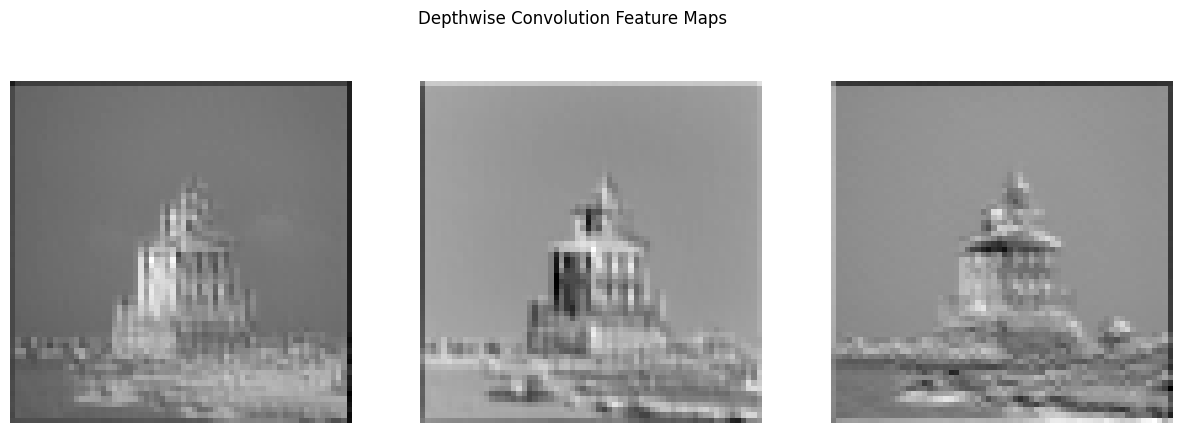

In [6]:
# Create the layer
C = x.shape[1]  # Number of input channels
depthwise_conv_layer = DepthwiseConvLayer(in_channels=C, kernel_size=3)

# Apply the layer to the input
y1 = depthwise_conv_layer(x)

# Visualize the feature maps
visualize_feature_maps(y1, title='Depthwise Convolution Feature Maps')

### Equation 2: Self-attention

In [7]:

class SelfAttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttentionLayer, self).__init__()
        self.in_channels = in_channels

    def forward(self, x):
        batch_size, C, H, W = x.size()
        N = H * W  # Number of positions
        x_flat = x.view(batch_size, C, N)  # Shape: [batch_size, C, N]
        x_flat_t = x_flat.permute(0, 2, 1)  # Shape: [batch_size, N, C]
        
        # Compute similarity scores
        attention_scores = torch.bmm(x_flat_t, x_flat)  # Shape: [batch_size, N, N]
        
        # Apply softmax
        attention_probs = F.softmax(attention_scores, dim=-1)  # Shape: [batch_size, N, N]
        
        # Compute the output
        out = torch.bmm(x_flat, attention_probs)  # Shape: [batch_size, C, N]
        out = out.view(batch_size, C, H, W)
        
        return out, attention_probs

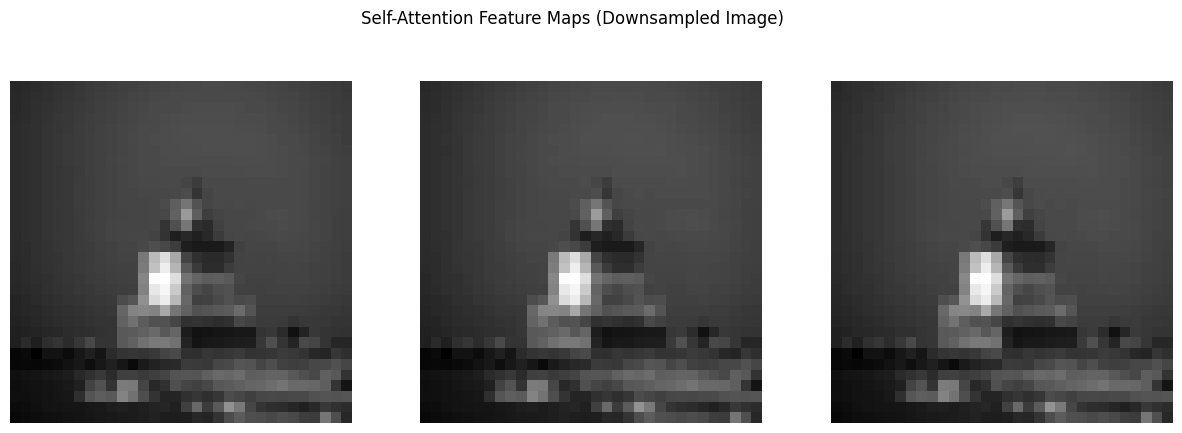

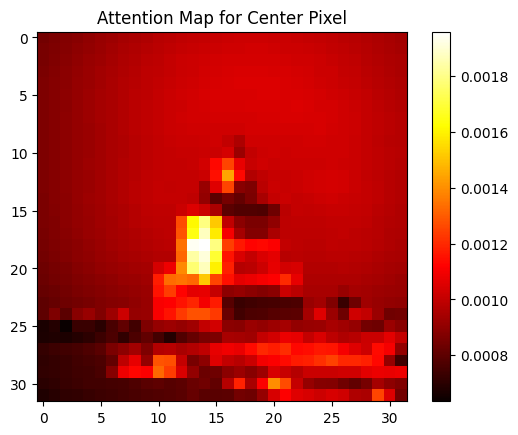

In [8]:
# Create the layer
self_attention_layer = SelfAttentionLayer(in_channels=x_small.shape[1])

# Apply the layer to the input
y2, attention_probs = self_attention_layer(x_small)

# Visualize the feature maps
visualize_feature_maps(y2, title='Self-Attention Feature Maps (Downsampled Image)')

# Visualize attention map for a selected position (e.g., center pixel)
H, W = x_small.shape[2], x_small.shape[3]
N = H * W
center_idx = (H // 2) * W + (W // 2)

# Get the attention weights for the center pixel
attention_map = attention_probs[0, center_idx, :]  # Shape: [N]

# Visualize the attention map
visualize_attention_map(attention_map, H, W, title='Attention Map for Center Pixel')

### Equation 3: Post-normalization Combination

In [9]:
class PostNormalizationCombinationLayer(nn.Module):
    def __init__(self, in_channels):
        super(PostNormalizationCombinationLayer, self).__init__()
        self.in_channels = in_channels
        self.depthwise_conv = nn.Conv2d(
            in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels
        )
    
    def forward(self, x):
        batch_size, C, H, W = x.size()
        N = H * W  # Number of spatial positions
        
        # Flatten the spatial dimensions
        x_flat = x.view(batch_size, C, N)             # Shape: [batch_size, C, N]
        x_flat_t = x_flat.permute(0, 2, 1)            # Shape: [batch_size, N, C]
        
        # Self-attention scores
        attention_scores = torch.bmm(x_flat_t, x_flat)  # Shape: [batch_size, N, N]
        attention_probs = F.softmax(attention_scores, dim=-1)  # Shape: [batch_size, N, N]
        
        # Convolutional weights
        conv_output = self.depthwise_conv(x)  # Shape: [batch_size, C, H, W]
        conv_output_flat = conv_output.view(batch_size, C, N)  # Shape: [batch_size, C, N]
        
        # **Combining Attention and Convolution**
        # We need to align the dimensions for broadcasting:
        # attention_probs: [batch, N, N] -> [batch, 1, N, N]
        # conv_output_flat: [batch, C, N] -> [batch, C, 1, N]
        attention_probs_expanded = attention_probs.unsqueeze(1)  # Shape: [batch, 1, N, N]
        conv_output_expanded = conv_output_flat.unsqueeze(2)    # Shape: [batch, C, 1, N]
        
        # Combined weights: [batch, C, N, N] = attention_probs + W_{i-j}
        combined_weights = attention_probs_expanded + conv_output_expanded  # Broadcasting addition
        
        # **Applying Combined Weights to Input Features**
        # x_flat: [batch, C, N] -> [batch, C, N, 1]
        x_j = x_flat.unsqueeze(3)  # Shape: [batch, C, N, 1]
        
        # Multiply and sum over j
        # [batch, C, N, N] * [batch, C, N, 1] = [batch, C, N, N]
        multiplied = combined_weights * x_j  # Element-wise multiplication
        out = multiplied.sum(dim=3)  # Sum over j: Shape: [batch, C, N]
        
        # Reshape back to [batch, C, H, W]
        out = out.view(batch_size, C, H, W)
        
        # Optionally, return attention probabilities for further analysis
        return out, attention_probs

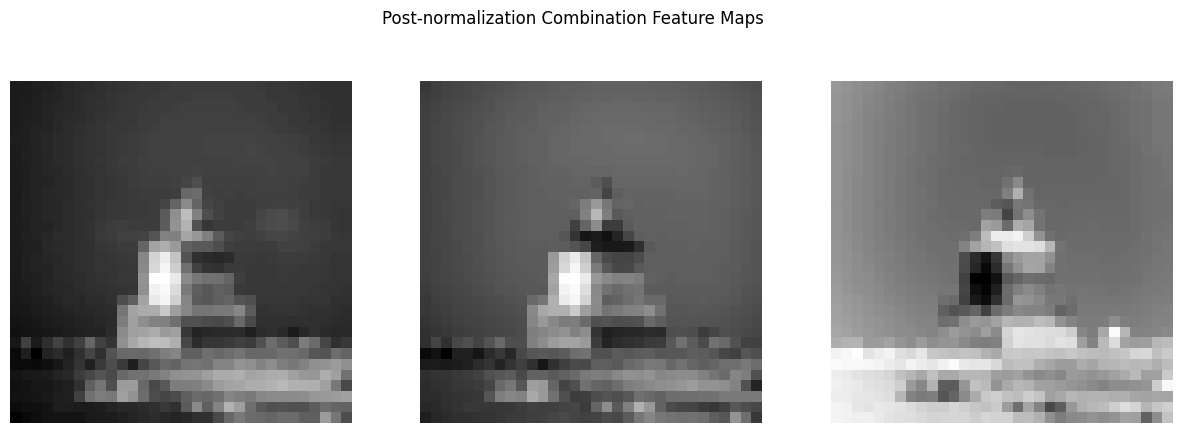

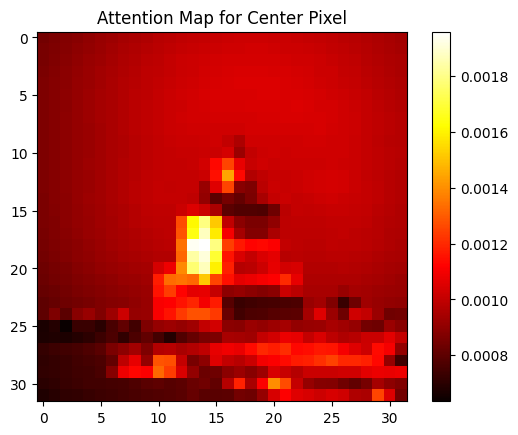

In [10]:
# Create the layer
post_norm_combination_layer = PostNormalizationCombinationLayer(in_channels=x_small.shape[1])

# Apply the layer to the input
y3, attention_probs3 = post_norm_combination_layer(x_small)
attention_map = attention_probs3[0, center_idx, :]  # Shape: [N]

# Visualize the feature maps
visualize_feature_maps(y3, title='Post-normalization Combination Feature Maps')
visualize_attention_map(attention_map, H, W, title='Attention Map for Center Pixel')

### Equation 4: Pre-normalization Combination

In [11]:
class PreNormalizationCombinationLayer(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super(PreNormalizationCombinationLayer, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        # Initialize convolution kernel for depthwise convolution
        self.depthwise_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            padding=self.padding,
            bias=False
        )

    def forward(self, x):
        batch_size, C, H, W = x.size()
        N = H * W
        x_flat = x.view(batch_size, C, N)             # [batch_size, C, N]
        x_flat_t = x_flat.permute(0, 2, 1)            # [batch_size, N, C]
        
        # Self-attention scores
        attention_scores = torch.bmm(x_flat_t, x_flat)  # [batch_size, N, N]
        
        # Convolution weights
        conv_output = self.depthwise_conv(x)  # [batch_size, C, H, W]
        conv_output_flat = conv_output.view(batch_size, C, N)  # [batch_size, C, N]
        
        # Element-wise addition of convolution output (broadcasted)
        conv_output_flat_t = conv_output_flat.permute(0, 2, 1)  # [batch_size, N, C]
        
        # Add convolutional results to the attention scores (broadcast across channels)
        attention_scores = attention_scores + conv_output_flat_t.mean(dim=-1, keepdim=True)  # [batch_size, N, N]
        
        # Softmax normalization
        combined_probs = F.softmax(attention_scores, dim=-1)  # [batch_size, N, N]
        
        # Multiply by x_j (input features)
        out = torch.bmm(x_flat, combined_probs)  # [batch_size, C, N]
        out = out.view(batch_size, C, H, W)
        
        return out


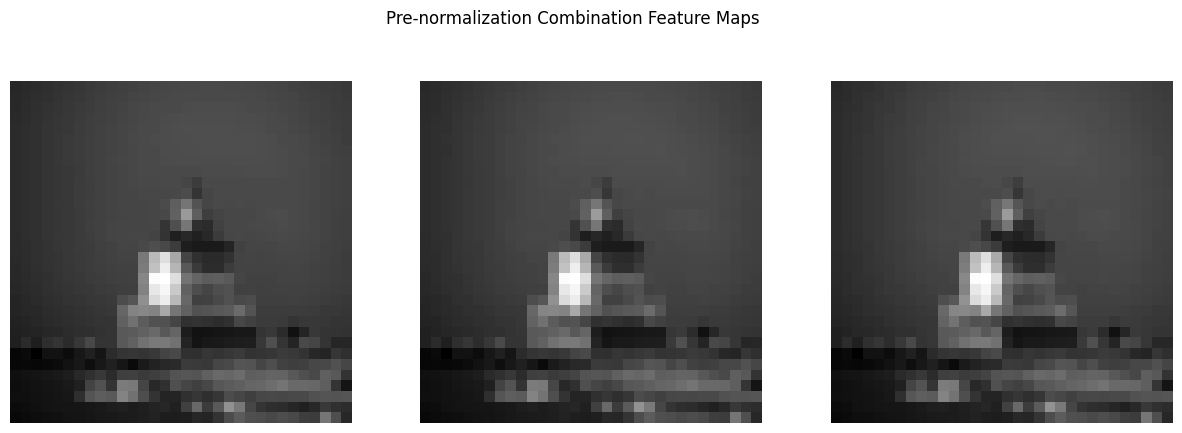

In [12]:
# Create the layer
pre_norm_combination_layer = PreNormalizationCombinationLayer(in_channels=x_small.shape[1])

# Apply the layer to the input
y4 = pre_norm_combination_layer(x_small)

# Visualize the feature maps
visualize_feature_maps(y4, title='Pre-normalization Combination Feature Maps')

### Equation 5: Attention Modulated Convolution

In [13]:
class AttentionModulatedConvolutionLayer(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super(AttentionModulatedConvolutionLayer, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        
        # Depthwise convolution for spatial weights
        self.depthwise_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            padding=self.padding,
            bias=False
        )
        
        # 1x1 convolutions to get query and key vectors
        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        # Learnable scaling factor for the score
        self.score_scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        batch_size, C, H, W = x.size()

        # Compute query and key vectors
        Q = self.query_conv(x)  # [batch_size, C, H, W]
        K = self.key_conv(x)    # [batch_size, C, H, W]

        # Compute scores based on query and key similarity
        # Here we use element-wise multiplication to get the attention scores
        scores = Q * K  # [batch_size, C, H, W]

        # Scale the scores
        scores = scores / (self.in_channels ** 0.5)

        # Apply softmax across the spatial dimensions to get attention probabilities
        attention_probs = F.softmax(scores.view(batch_size, C, -1), dim=-1)  # [batch_size, C, H*W]
        attention_probs = attention_probs.view(batch_size, C, H, W)  # [batch_size, C, H, W]

        # Modulate the input features with attention probabilities
        modulated_input = attention_probs * x  # [batch_size, C, H, W]

        # Apply depthwise convolution after modulating the input features
        out = self.depthwise_conv(modulated_input)  # [batch_size, C, H, W]

        return out


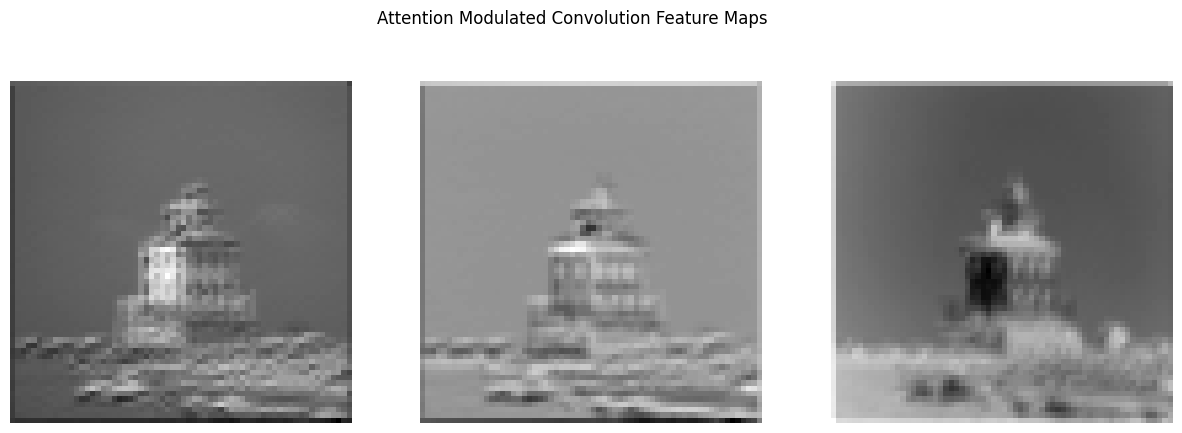

In [14]:
# Create the layer
attention_modulated_conv_layer = AttentionModulatedConvolutionLayer(in_channels=x.shape[1])

# Apply to the input
y5 = attention_modulated_conv_layer(x)

# Visualize the feature maps
visualize_feature_maps(y5, title='Attention Modulated Convolution Feature Maps')

### Equation 6: Convolution Modulated Attention

In [15]:
class ConvolutionModulatedAttentionLayer(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super(ConvolutionModulatedAttentionLayer, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.depthwise_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            padding=kernel_size//2,
            bias=False
        )

    def forward(self, x):
        # Depthwise convolution
        DWConv_output = self.depthwise_conv(x)
        # Apply softmax over the channel dimension
        attention_map = F.softmax(DWConv_output, dim=1)
        # Element-wise multiplication with the value tensor (x)
        out = attention_map * x
        return out, attention_map

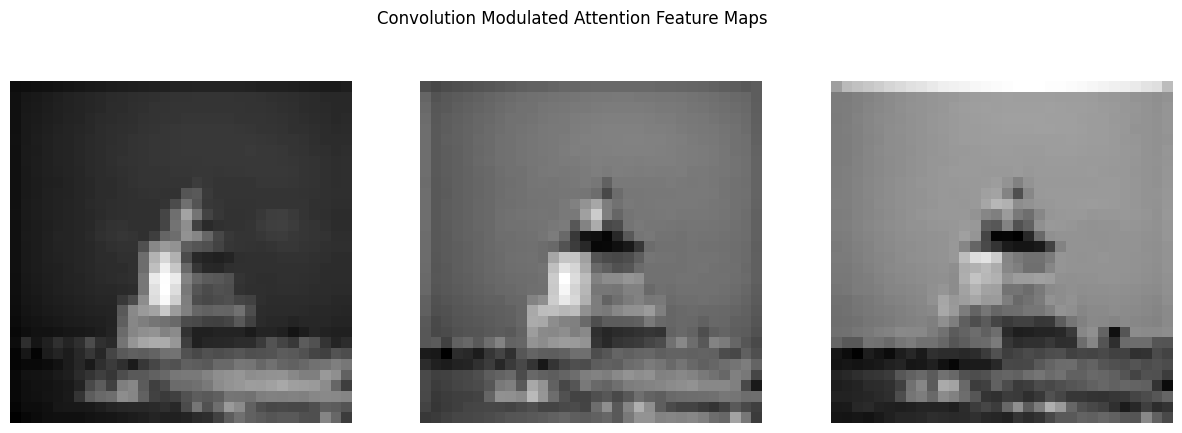

In [16]:
# Create the layer
conv_modulated_attention_layer = ConvolutionModulatedAttentionLayer(in_channels=x.shape[1])

# Apply to the input
y6, attention_map = conv_modulated_attention_layer(x_small)

# Visualize the feature maps
visualize_feature_maps(y6, title='Convolution Modulated Attention Feature Maps')


For the attention maps, the visualization assumes that the attention is computed over the channel dimension or spatial dimensions appropriately. Adjust the visualization code according to the actual dimensions over which the softmax is applied.

# Information Propagation and Receptive Fields




1a) The information for pixel y_i​ is derived from a small local region (receptive field) around pixel i. The size of this receptive field is dictated by the kernel size. Each pixel X_j​ within the local neighborhood L(i) contributes to the output pixel y_i​ via weighted sums, but only from the local area.

1b) The receptive field for each pixel y_i depends on the kernel size, but it is local in nature. The information propagates only within the local region.

2a) Here, every pixel yiyi​ can receive information from all other pixels in the global context GG. The weighting of information is based on the similarity between the pixels, as captured by the dot product. The attention mechanism allows for long-range dependencies to be captured, as any pixel jj in the image can influence pixel ii if their features are sufficiently similar.

2b) Global receptive field. Every pixel can potentially attend to every other pixel in the image, enabling long-range interactions.

3a) The information propagated to pixel yi​ comes from both the local convolution (from nearby pixels j∈L(i)) and the global attention mechanism (from all pixels j∈G). This combination allows each pixel to gather information both from its local neighborhood and from globally similar pixels, combining local and global context.

3b) The receptive field is global, but local neighborhood information from convolution is incorporated either after or before normalization, respectively. The receptive field is enlarged compared to just convolution alone, as it incorporates information from the entire image (self-attention) alongside the local convolution.

4a) The attention weights now factor in the convolutional kernel, so the influence of each pixel j on pixel i depends not just on their similarity (as in self-attention) but also on their spatial proximity (as captured by the convolution kernel). This creates a more intricate blending of local and global information.

4b) The receptive field is global, but local neighborhood information from convolution is incorporated either after or before normalization, respectively. Similar to the post-normalization combination, the receptive field includes the entire image due to the global attention, but the convolution weights are incorporated before computing the attention scores.

5a) Each pixel Y(i) receives information from its local neighborhood L(i), but the contribution of each pixel j is modulated by an attention mechanism. This allows the convolution to focus more on important pixels within the local region.

5b) Receptive field remains local, but attention weights allow selective emphasis within this local region.

6a) Each pixel’s attention weight is determined by a convolution applied to the entire feature map. This adds spatial context to the attention mechanism.
The attention-weighted features V are modulated by this spatially aware attention mechanism.

6b) The receptive field is determined by the size of the depthwise convolution kernel, but it influences the attention weights globally through spatial modulation. The receptive field depends on the convolution kernel size F×F, meaning the attention mechanism can only focus on a fixed local region around each pixel.
